# EELS SrFeO Project 
## sketchy & messy

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN Autoencoder

* <span style="color: red"> // put resources here // </span>

### Import Package

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [19]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [5]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

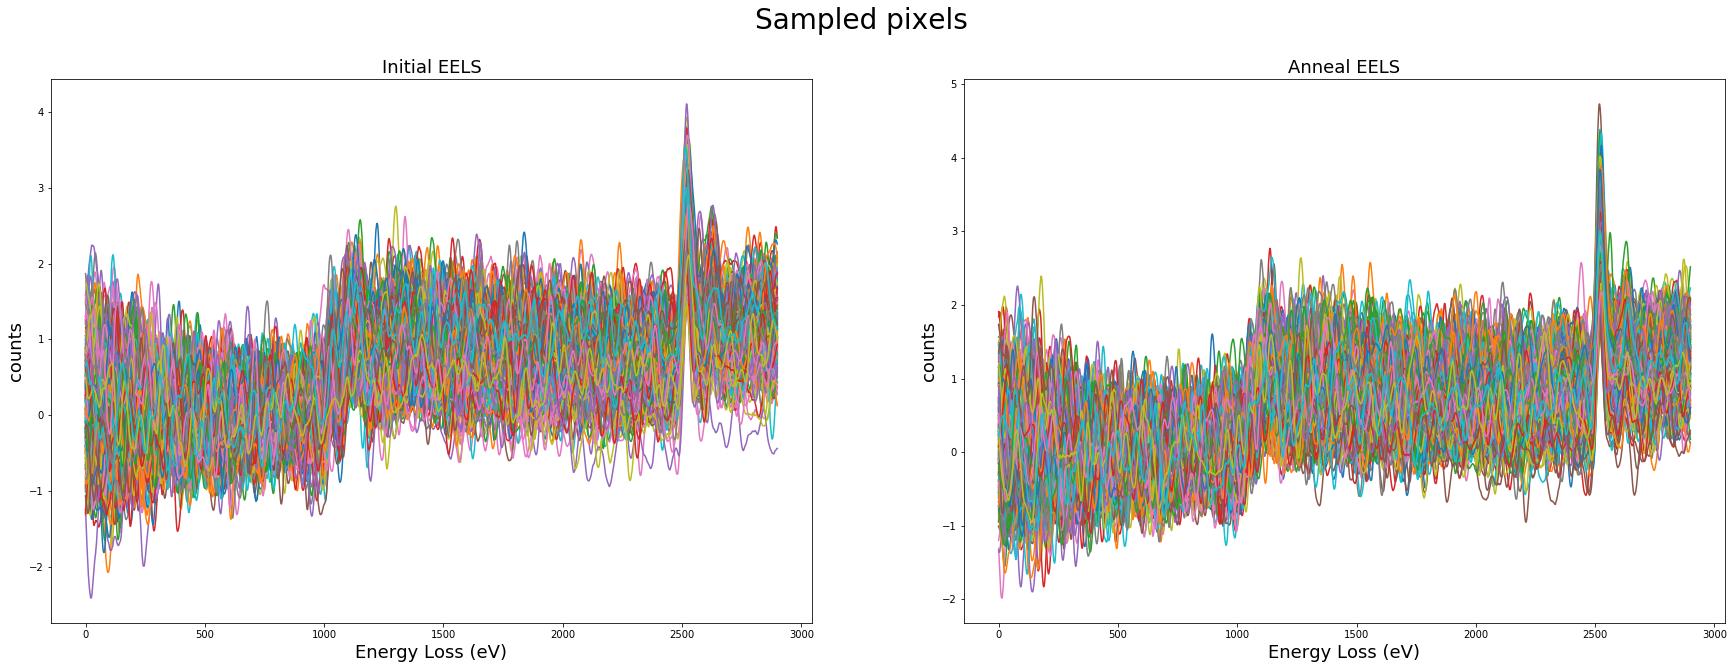

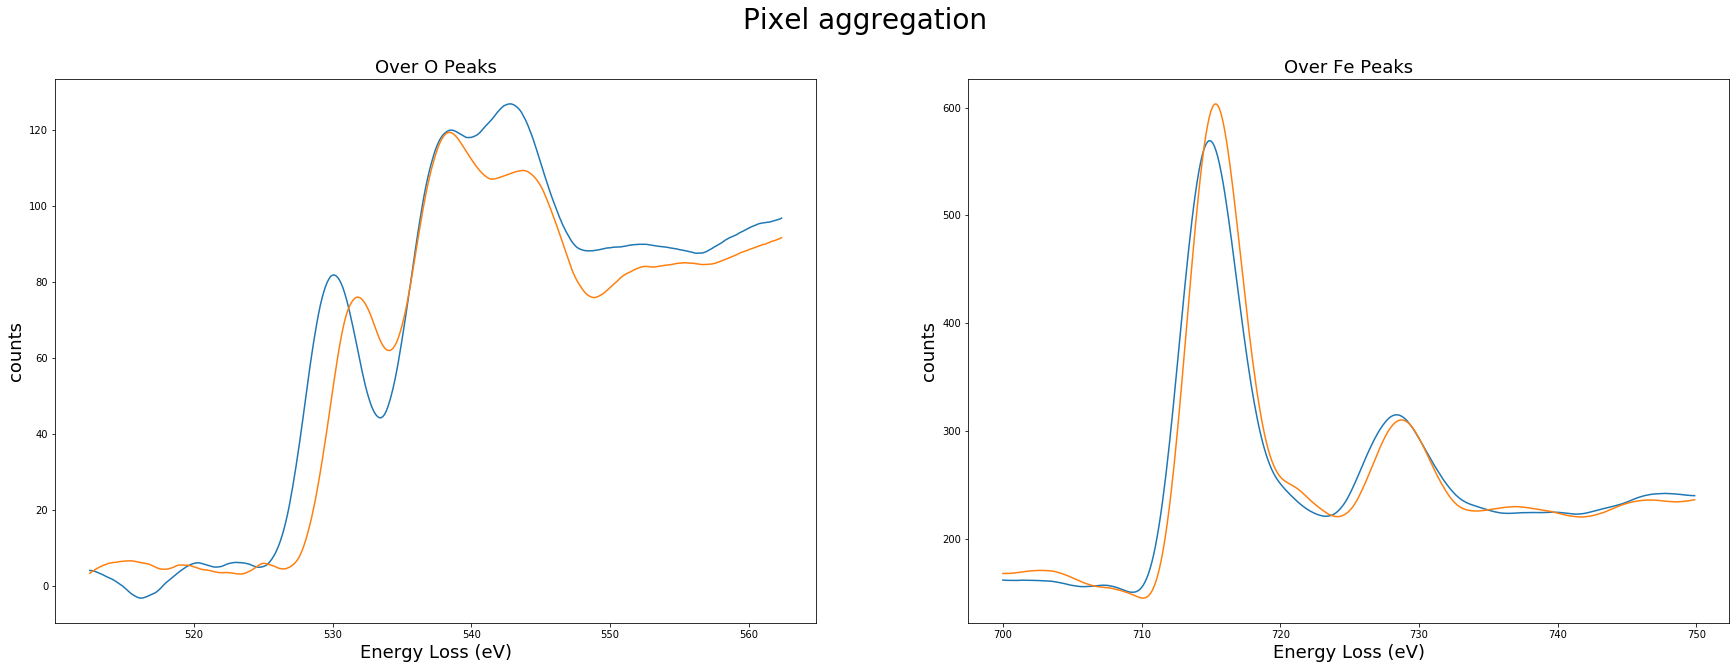

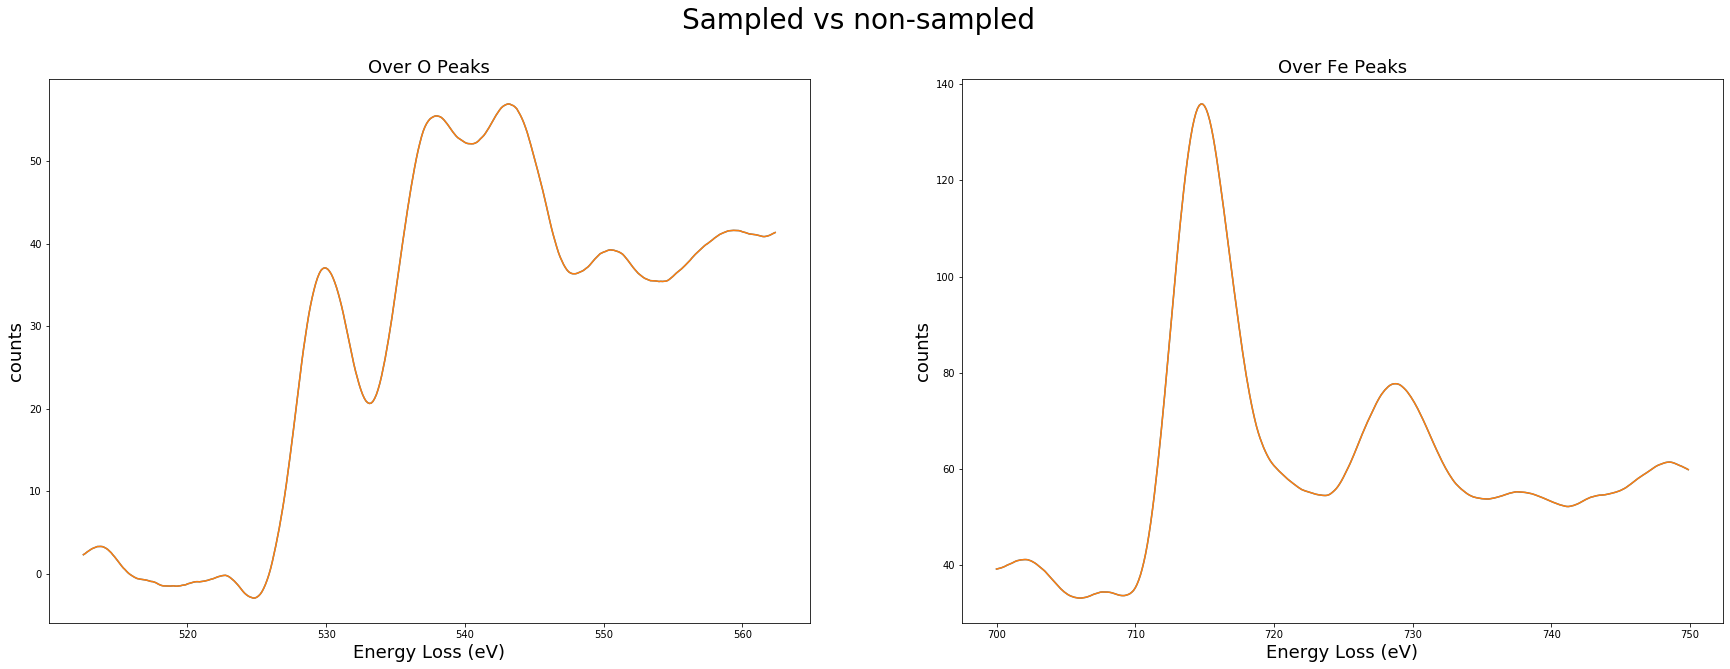

(20, 20, 300)
(20, 20, 300, 128)
(120000, 128)
(120000, 2)


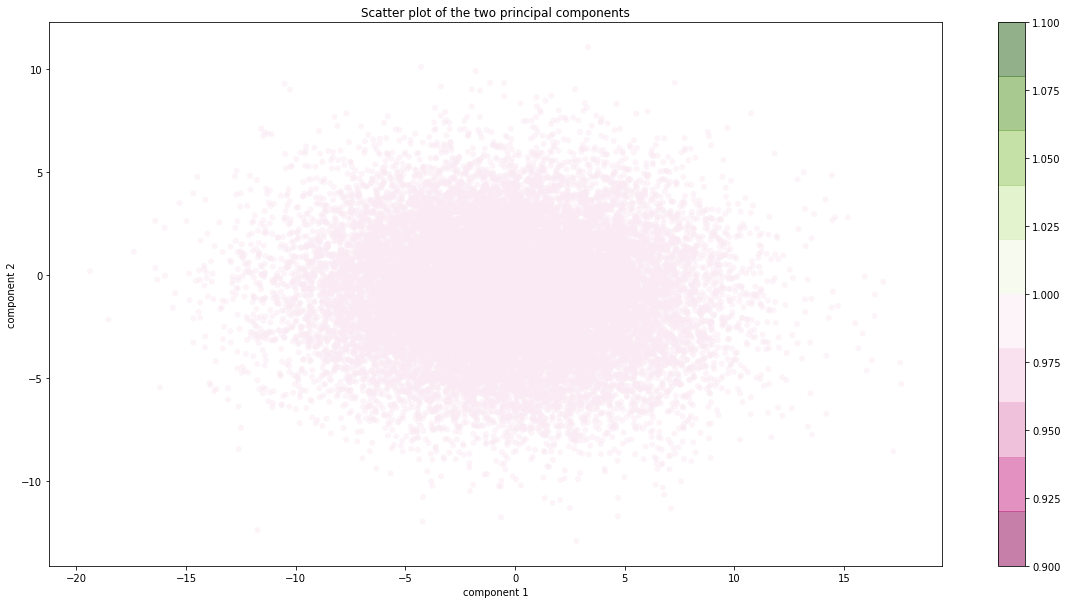

In [304]:
%run ./1_DataPrep.ipynb

In [305]:
# stranslate labels into 2d
data_target = []
for i in data_tar:
    if i == 0:  # 0 means initial
        data_target.append([1,0])
    elif i == 1: # 1 means annealed
        data_target.append([0,1])
data_target = np.array(data_target)

In [306]:
data_ana.shape

(120000, 128)

In [308]:
data_tar.shape

(120000,)

#### nxn average pooling on EELS images

In [692]:
window = 2*2
# The window setup here is not physically correct, but you get the point of this operation
data_ana_2 = list()
data_target_2 = list()
for i in range(int(data_ana.shape[0]/window)):
    data_ana_2.append(np.average(data_ana[i*window:i*window+window],axis=0))
    data_target_2.append(np.average(data_target[i*window:i*window+window],axis=0))
data_ana_2 = np.array(data_ana_2)
data_target_2 = np.array(data_target_2)
print(data_ana_2.shape)
print(data_target_2.shape)

(30000, 128)
(30000, 2)


#### Shuffling X,Y

In [693]:
# Shuffling the input
X = list()
Y = list()
placeholder = np.arange(data_ana_2.shape[0])
np.random.shuffle(placeholder)
for i in placeholder:
    X.append(data_ana_2[i])
    Y.append(data_target_2[i])
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(30000, 128)
(30000, 2)


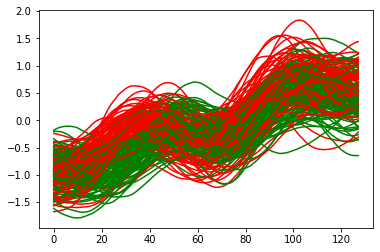

In [694]:
for i in range(100):
    plt.plot(data_ana_2[i], color='red')
    plt.plot(data_ana_2[-i], color='green')

#### test-train split

In [698]:
# test-train split
#length = data_ana.shape[0]
length = 24000 # = total length - validation length
ttsplit = 0.80 # ratio train to test sets
split = round(length*ttsplit)

x_train = np.atleast_3d(np.array(X[0:split]))
y_train = np.array(Y[0:split])
x_test = np.atleast_3d(np.array(X[split:length]))
y_test = np.array(Y[split:length])
x_validate = np.atleast_3d(np.array(X[length:]))
y_validate = np.array(Y[length:])

In [699]:
# check training data shape
print(x_train.shape)
print(y_train.shape)

(19200, 128, 1)
(19200, 2)


In [700]:
# check testing data shape
print(x_test.shape)
print(y_test.shape)

(4800, 128, 1)
(4800, 2)


In [34]:
# checking device (GPU & CPU)
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5173053241859719537
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13542397428813602607
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10598757172
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17860845222453566759
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:05:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10658401485
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14963678856450958487
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3725701033409061076
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type

In [701]:
# check validate data shape
print(x_validate.shape)
print(y_validate.shape)

(6000, 128, 1)
(6000, 2)


In [702]:
np.average(data_target_2)

0.5

## <span style="color: red">** **Fake data for model eval** </span>

In [13]:
# fake dataset -- Trying to evaluate the model
import math
import numpy as np

M = 128 # number of energy channels
N = 10000 # number of datapoints
X,Y,U,W = list(),list(),list(),list()
data_1,data_2,data_3,data_4 = list(),list(),list(),list()

for k in range(round(N/2)): # datapoints doubles per iteration
    #np.random.seed(k)
    data_1.clear()
    data_2.clear()
    for i in np.arange(M):
        data_1.append(math.cos(float(i/64))+np.random.random()*2) # arbi function 1
        data_2.append(math.cos(float(i/64)*2)+np.random.random()*2) # arbi function 2
        data_3.append(math.cos(float(i/64))+1) # arbi function 1
        data_4.append(math.cos(float(i/64)*2)+1) # arbi function 2
    X.append(np.copy(data_1))
    Y.append([1,0])
    X.append(np.copy(data_2))
    Y.append([0,1])
    W.append(np.copy(data_3))
    U.append(np.copy(data_4))
#X = np.atleast_3d(np.array(X))
X = np.array(X)
Y = np.array(Y)
U = np.array(U)
W = np.array(W)

Text(0.5, 1.0, 'Autoencoder on fake data')

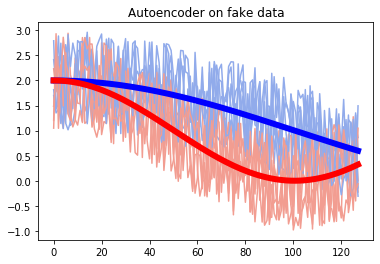

In [7]:
for i in range(0,10,2):
    plt.plot(X[i], color='#91abeb')
    plt.plot(X[i+1], color='#f29d91')
plt.plot(W[0], color='b', lw=6)
plt.plot(U[0], color='r', lw=6)
plt.title('Autoencoder on fake data')

In [14]:
# Shuffles data
X = np.atleast_3d(X)
placeholder = np.arange(X.shape[0])
np.random.shuffle(placeholder)
a,b = list(),list()
for i in placeholder:
    a.append(X[i])
    b.append(Y[i])
X=np.array(a)
Y=np.array(b)

In [15]:
# test-train split
length = 8000
ttsplit = 0.80 # ratio train to test sets
split = round(length*ttsplit)

x_train = np.atleast_3d(np.array(X[0:split]))
y_train = np.array(Y[0:split])
x_test = np.atleast_3d(np.array(X[split:length]))
y_test = np.array(Y[split:length])
x_validate = np.atleast_3d(np.array(X[length:]))
y_validate = np.array(Y[length:])

In [16]:
print(x_train.shape)
print(y_train.shape)

(6400, 128, 1)
(6400, 2)


In [17]:
print(x_test.shape)
print(y_test.shape)

(1600, 128, 1)
(1600, 2)


In [18]:
print(x_validate.shape)
print(y_validate.shape)

(2000, 128, 1)
(2000, 2)


### Setting up RNN autoencoder

In [172]:
size = 128
N_encode = 4
N_decode = 4
embed = 2
N_steps = 128
drop_frac = 0.02
l1_norm = 1e-4

model2 = Sequential()
model2.add(LSTM(size, 
               return_sequences=(N_encode > 1), 
               dropout=drop_frac, 
               input_shape=(N_steps, 1)))
for i in range(1, N_encode):
    model2.add(LSTM(size, return_sequences=(i < N_encode - 1), dropout=drop_frac))
model2.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))
# builds the repeat vector
model2.add(RepeatVector(N_steps))
# builds the decoding layer
for i in range(N_decode):
    model2.add(LSTM(size, return_sequences=True, dropout=drop_frac))
# builds the time distributed layer to reconstruct the original input
model2.add(TimeDistributed(Dense(1, activation='linear')))

In [173]:
# model.summary()

In [174]:
# set learning rate and compile model
lr = 3e-3
model2.compile(Adam(lr), loss='mse')

In [175]:
# fits the model
model2.fit(x_train, x_train, 
          epochs=5, batch_size=200, 
          validation_data=(x_test, x_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 111s 17ms/step - loss: 0.6778 - val_loss: 0.6949
Epoch 2/5
6400/6400 [==============================] - 101s 16ms/step - loss: 0.5115 - val_loss: 0.5055
Epoch 3/5
6400/6400 [==============================] - 108s 17ms/step - loss: 0.3686 - val_loss: 0.2537
Epoch 4/5
6400/6400 [==============================] - 87s 14ms/step - loss: 0.2501 - val_loss: 0.2435
Epoch 5/5
6400/6400 [==============================] - 79s 12ms/step - loss: 0.2446 - val_loss: 0.2453


In [176]:
y_predict = model2.predict(np.atleast_3d(x_validate))

In [1]:
x_validate.shape

NameError: name 'x_validate' is not defined

In [178]:
y_predict.shape

(2000, 128, 1)

Text(0.5, 0.98, 'Spectra Prediction')

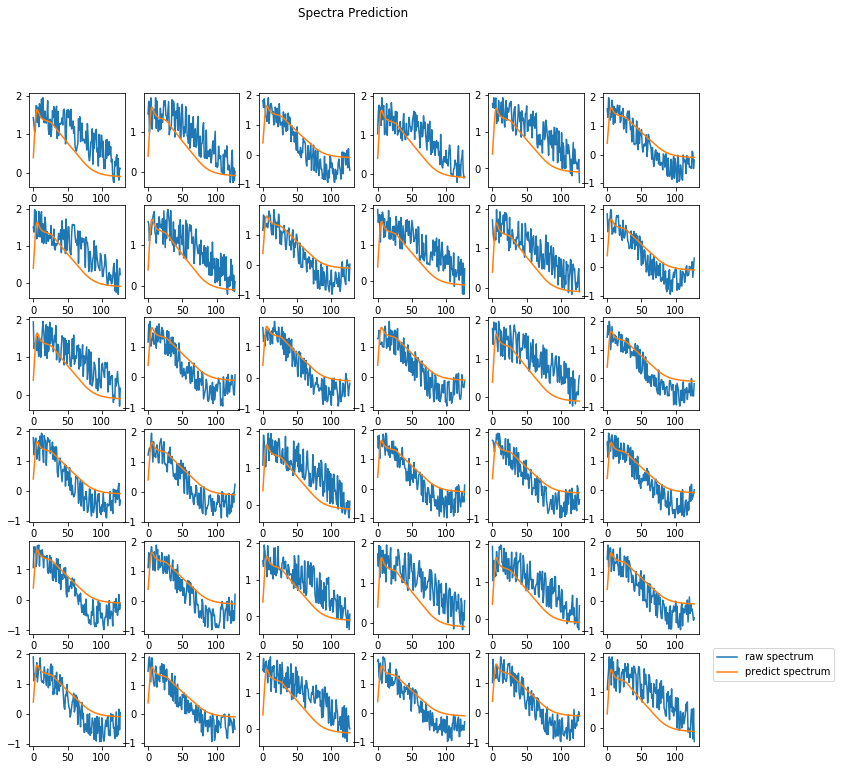

In [179]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(6, 6, figsize=(12, 12))
from sklearn import preprocessing
#y1_norm = preprocessing.normalize(x_test)
#y2_norm = preprocessing.normalize(y_predict.reshape(-1,128))
y1_norm = x_validate
y2_norm = y_predict.reshape(-1,128)
axs.reshape(-1)
for i in range (0,6):
    for j in range(0,6):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
fig.suptitle("Spectra Prediction")

## Applying RNN Autoencoder to temporal data

In [2]:
# loading initial data
temporal_data = hs.load('temporal_data/EELS Spectrum ImageFrames/EELS Spectrum Image_*.dm4', signal_type="EELS", stack=False)

In [3]:
temporal_data[0].data.shape

(36, 114, 3710)

### Dark reference
Software used to collect EELS data has some glitches. Dark reference is provided and must be added to each spectrum.

In [4]:
def add_dark_ref(stacked_data, dark_ref):
    """
    Add dark references to EELS dataset
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    dark_ref: 1d array
        dark reference for correction
    """
    dim = stacked_data[0].data.shape
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].data[i][j] = np.sum([stacked_data[k].data[i][j],dark_ref.data], axis=0)

In [8]:
# Add dark references

dark_ref = hs.load('temporal_data/EELS Spectrum ImageFrames/bkg.dm4', signal_type="EELS")
add_dark_ref(temporal_data, dark_ref)

In [10]:
new_data = hs.load('temporal_data/EELS Spectrum ImageFrames/EELS Spectrum Image_40.dm4', signal_type="EELS")

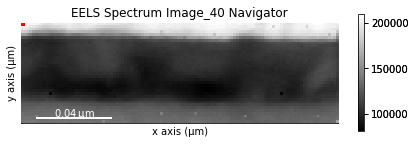

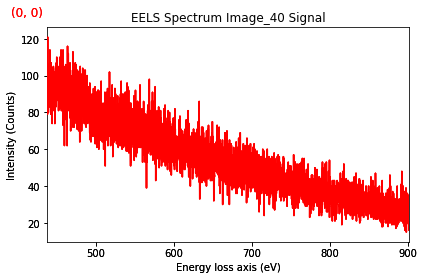

In [11]:
new_data.plot()

### Cropping image

(12, 114)


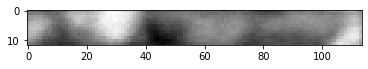

In [12]:
# Visualizing cropped area
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

harvest = np.average(temporal_data[0].data[8:20], axis=(2))
print(harvest.shape)


fig, ax = plt.subplots()
im = ax.imshow(harvest)

In [13]:
# window is y = [8:20]
def crop(data):
    for k,sp in enumerate(temporal_data):
        temporal_data[k].data = sp.data[8:20]
        print(temporal_data[k].data.shape)

In [14]:
crop(temporal_data)

(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)
(12, 114, 3710)


### Background Subtraction 

Jamie suggested performing background subtraction based on power law fit. $I = A*E^r$
* I is the measured intensity, 
* A is a constant
* E is the energy-loss value (eV)
* r is an exponent (usually around 3)

Select an energy window (around 50 eV wide) at around a few eV before the region of interest to fit A and r.

#### Resources
https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes \
https://scipy-cookbook.readthedocs.io/items/FittingData.html \
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [15]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)
'''
import scipy.optimize # curve_fit

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = np.arange(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = np.arange(100,data1.shape[2],1) 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4e+02, -1e-04])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            print(popt, end="\r")
    return data2, popt

def subtract_bckgrnd_and_filter(data):
    backgroundregion = np.arange(100,500,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].data, popt = subtractExpBackground(spectra.data,backgroundregion)
        data[k].data = scipy.signal.savgol_filter(data[k].data, 51, 3) # window size 50, polynomial order 3
        print("iteration: {}{}".format(k,popt))

In [16]:
subtract_bckgrnd_and_filter(temporal_data)

iteration: 0[ 5.97186809e+01 -6.09366077e-04]
iteration: 1[ 6.02451044e+01 -7.09351941e-04]
iteration: 2[ 5.93978905e+01 -6.40791147e-04]
iteration: 3[ 6.14988317e+01 -7.78281383e-04]
iteration: 4[ 5.96600272e+01 -6.24992058e-04]
iteration: 5[ 5.70556894e+01 -5.40331816e-04]
iteration: 6[ 5.91970585e+01 -6.67810938e-04]
iteration: 7[ 5.86427215e+01 -6.67034751e-04]
iteration: 8[ 5.87639581e+01 -6.88098387e-04]
iteration: 9[ 5.84845768e+01 -6.58038870e-04]
iteration: 10[ 5.82612907e+01 -6.52226713e-04]
iteration: 11[ 6.04672123e+01 -7.62721060e-04]
iteration: 12[ 5.95110786e+01 -6.47478142e-04]
iteration: 13[ 6.01940863e+01 -7.00308974e-04]
iteration: 14[ 5.91086483e+01 -7.19637422e-04]
iteration: 15[ 5.71254144e+01 -6.22460604e-04]
iteration: 16[ 5.80649891e+01 -6.68502351e-04]
iteration: 17[ 5.89685392e+01 -7.66577636e-04]
iteration: 18[ 5.73148055e+01 -6.75160232e-04]
iteration: 19[ 5.87285371e+01 -7.20442391e-04]
iteration: 20[ 5.80897858e+01 -6.67560089e-04]
iteration: 21[ 5.506982

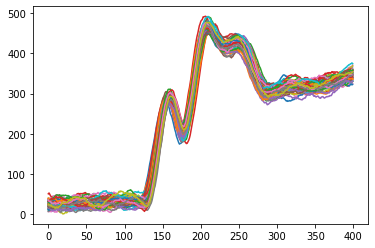

In [18]:
for k in range(49):
    plt.plot(np.sum(temporal_data[k].data[8:20,90:100,600:1000],axis=(0,1)))


### Downsampling

Done to reduce data size and noise. Trying out if it works.

#### Resources
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [19]:
from scipy.signal import resample

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].data.shape
    for k,sp in enumerate(stacked_data):
        stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled)      

In [20]:
#N_resampled = 1500
N_resampled = temporal_data[0].data.shape[2]

downsample(temporal_data, N_resampled)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

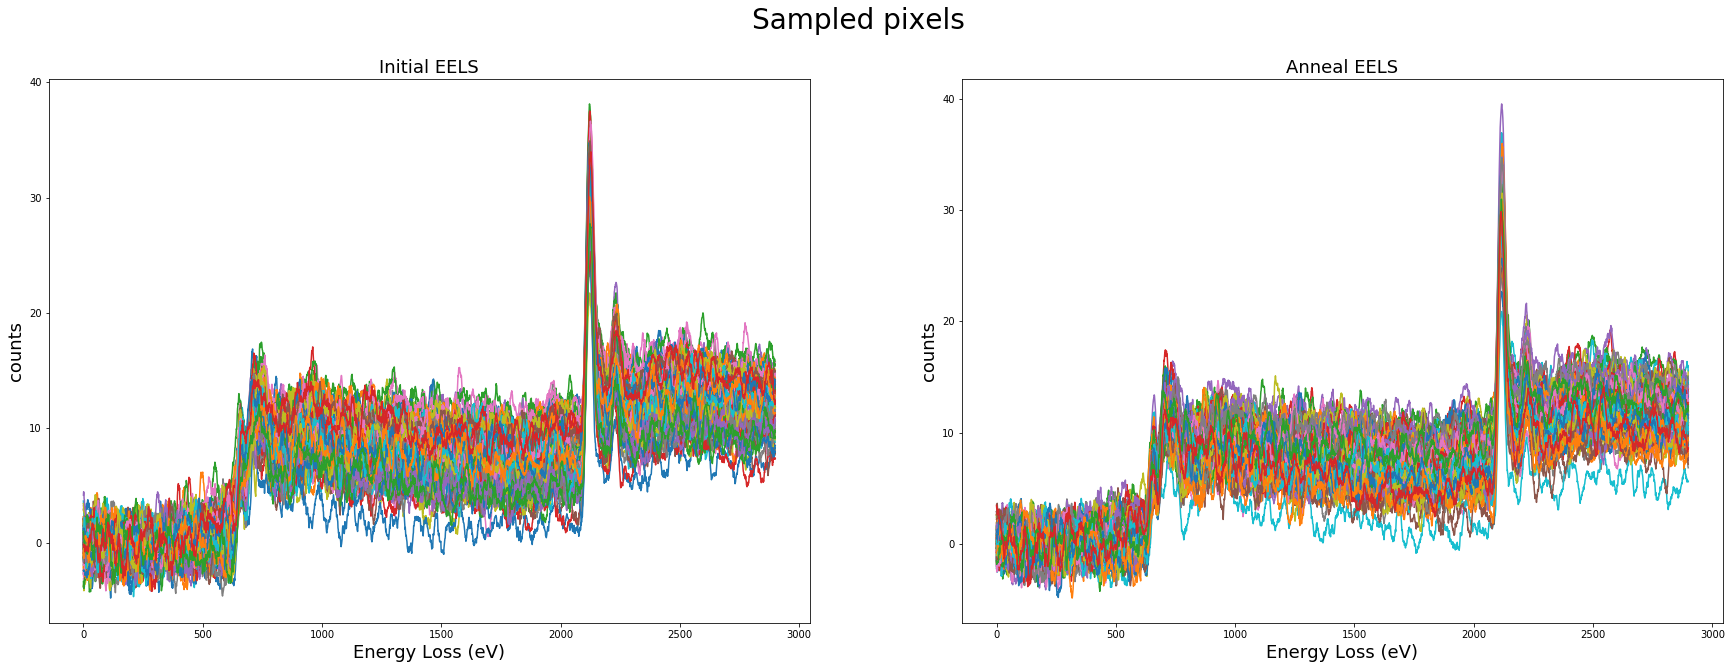

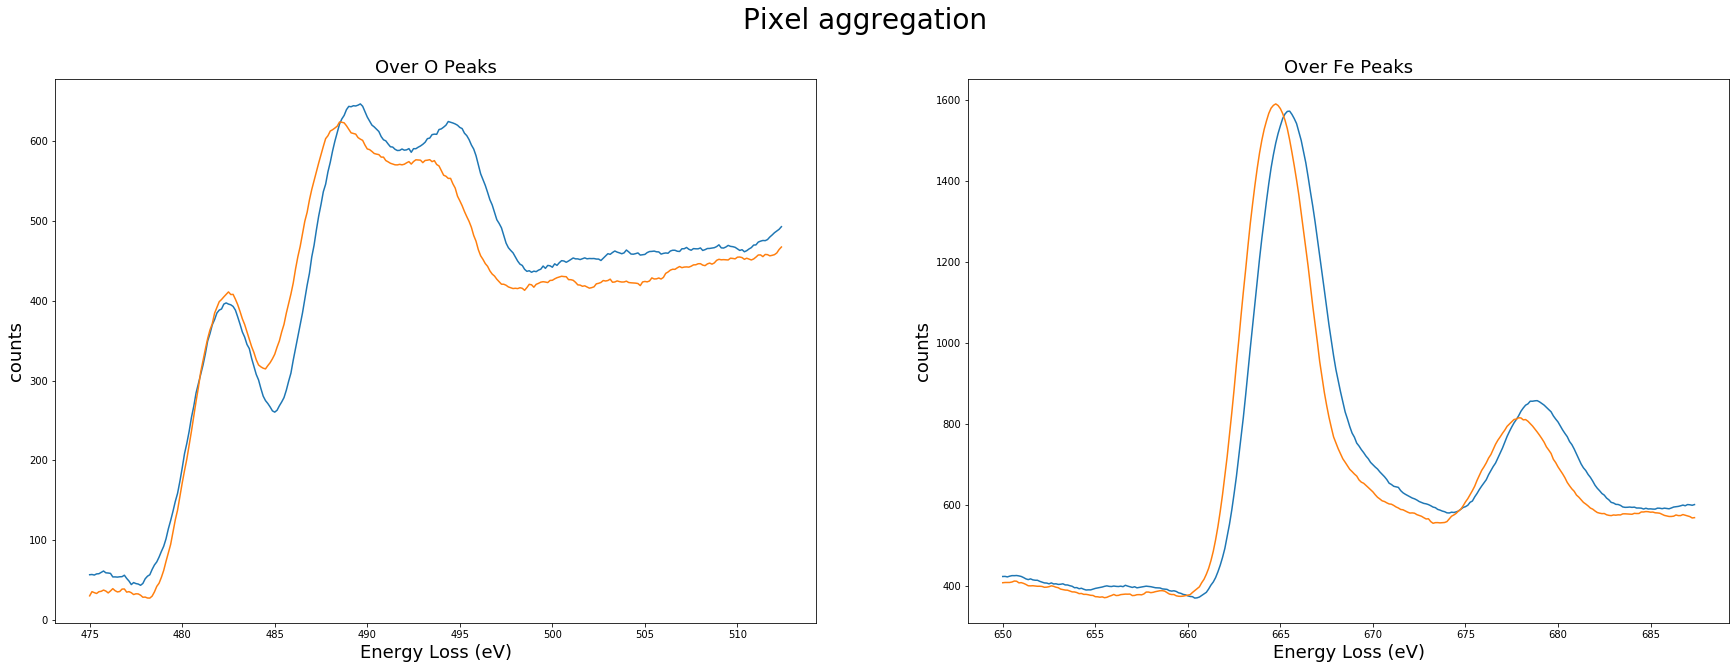

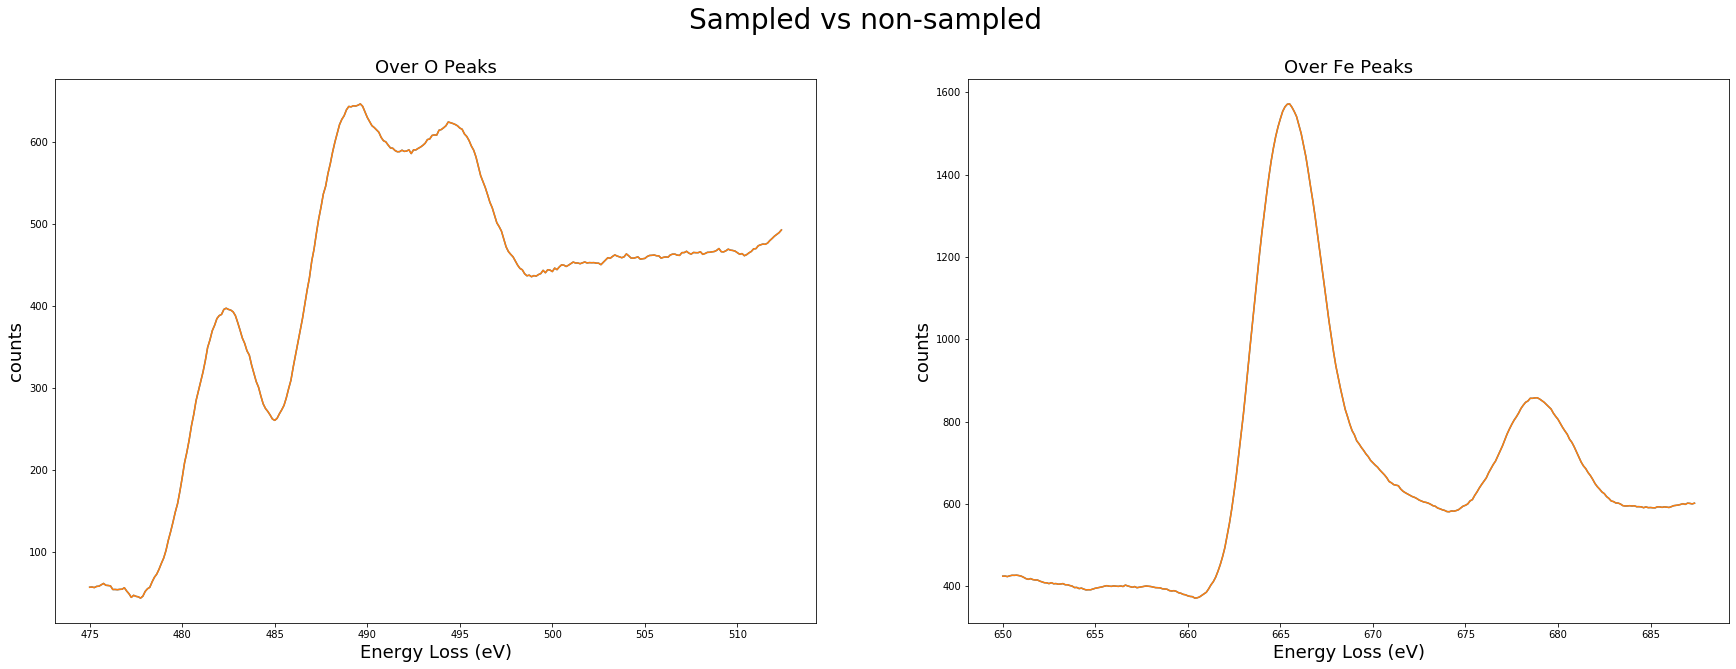

In [21]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV
frac = N_resampled/temporal_data[0].data.shape[2]
O_range = range(math.ceil(700*frac),math.ceil(1000*frac),1)
Fe_range = range(math.ceil(2100*frac),math.ceil(2400*frac),1)
O_xrange = [start+step*i/frac for i in O_range]
Fe_xrange = [start+step*i/frac for i in Fe_range]

# Plotting individual spectrum
f,(ax1,ax2) = plt.subplots(1,2, figsize=(30,10))
# initial data on image 3, [5,:,400:2500]
for i in temporal_data[3].resample[5]:
    ax1.plot(i[100:3000])
# plotting individual anneal data on image 3, [20,:,400:2500]
for i in temporal_data[40].resample[5]:
    ax2.plot(i[100:3000])

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
# Plotting aggregation over oxygen range
ax3.plot(O_xrange, np.sum(temporal_data[3].resample[5][50:100], axis=0)[O_range])
ax3.plot(O_xrange, np.sum(temporal_data[40].resample[5][50:100], axis=0)[O_range])
# Plotting aggregation over Fe range
ax4.plot(Fe_xrange, np.sum(temporal_data[3].resample[5][50:100], axis=0)[Fe_range])
ax4.plot(Fe_xrange, np.sum(temporal_data[40].resample[5][50:100], axis=0)[Fe_range])

# Plotting aggregared spectra (sampled vs non-sampled)
h,(ax5,ax6) = plt.subplots(1,2, figsize=(30,10))
# Plotting aggregation over oxygen range
ax5.plot(O_xrange, np.sum(temporal_data[3].resample[5][50:100], axis=0)[O_range])
ax5.plot([start+(i*step) for i in range(700,1000,1)], np.sum(temporal_data[3].data[5][50:100], axis=0)[700:1000])
# Plotting aggregation over Fe range
ax6.plot(Fe_xrange, np.sum(temporal_data[3].resample[5][50:100], axis=0)[Fe_range])
ax6.plot([start+(i*step) for i in range(2100,2400,1)], np.sum(temporal_data[3].data[5][50:100], axis=0)[2100:2400])

# plot configurations
f.suptitle('Sampled pixels', fontsize=28)

ax1.set_title('Initial EELS', fontsize=18)
ax1.set_xlabel('Energy Loss (eV)', fontsize=18)
ax1.set_ylabel('counts', fontsize=18)

ax2.set_title('Anneal EELS', fontsize=18)
ax2.set_xlabel('Energy Loss (eV)', fontsize=18)
ax2.set_ylabel('counts', fontsize=18)   

g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)   

h.suptitle('Sampled vs non-sampled', fontsize=28)
ax5.set_title('Over O Peaks', fontsize=18)
ax5.set_xlabel('Energy Loss (eV)', fontsize=18)
ax5.set_ylabel('counts', fontsize=18)   

ax6.set_title('Over Fe Peaks', fontsize=18)
ax6.set_xlabel('Energy Loss (eV)', fontsize=18)
ax6.set_ylabel('counts', fontsize=18)   

### Normalizing data

Normalizing data over the 2 regions of interest

resource: https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes/__init__.py

In [22]:
def normalize(data, data_normal=None,extra_output=None):
    """
    Normalizes the data
    
    Parameters
    ----------
    data : numpy, array
        data to normalize
    data_normal : numpy, (optional)
        data set to normalize with
        
    Returns
    -------
    data_norm : numpy, array
        Output of normalized data
    """

    if data_normal is None:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_norm.reshape(-1)))
        data_norm -= mean
        std = np.std(data_norm)
        data_norm /= std
    else:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_normal.reshape(-1)))
        data_norm -= mean
        std = np.std(data_normal)
        data_norm /= std
    if extra_output==None:
        return data_norm
    else:
        return data_norm, std, mean

In [23]:
for k,spectra in enumerate(temporal_data):
    temporal_data[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)

### Section out region of interest (ROI)

Here is from the manual observation of the data from the previous aggregate plot:
- analysis_range = 300 raw data points
- O_range = starts @ 700 [700:1000]
- Fe_range = starts @ 2100 [2100:2400]

In [24]:
def cut_ROI(data, N_resampled, anly_range:int=128):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_range)/N_0*N_resampled)))
        data[k].Fe_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_range)/N_0*N_resampled)))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][math.ceil(700/N_0*N_resampled):math.ceil((1000+anly_range)/N_0*N_resampled)]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][math.ceil(2100/N_0*N_resampled):math.ceil((2400+anly_range)/N_0*N_resampled)]

In [25]:
def cut_ROI(data, N_resampled, anly_range:int=128):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]

    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], 300))
        data[k].Fe_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], 300))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][700:1000]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][2100:2400]

In [26]:
cut_ROI(temporal_data, N_resampled)

In [27]:
arrayx = list()
for i in range(len(temporal_data)):
    temporal_data[i].O_range = temporal_data[i].O_range.reshape((-1,300))
    arrayx.append(temporal_data[i].O_range)
arrayx = np.array(arrayx).reshape((-1,300))

In [28]:
arrayx.shape

(67032, 300)

In [29]:
# test-train split
#length = data_ana.shape[0]
length = 50000 # = total length - validation length
ttsplit = 0.80 # ratio train to test sets
split = round(length*ttsplit)

x_train = np.atleast_3d(np.array(arrayx[0:split]))
x_test = np.atleast_3d(np.array(arrayx[split:length]))
x_validate = np.atleast_3d(np.array(arrayx[length:]))

In [30]:
# check training data shape
print(x_train.shape)

(40000, 300, 1)


In [31]:
# check testing data shape
print(x_test.shape)

(10000, 300, 1)


In [32]:
# check validate data shape
print(x_validate.shape)

(17032, 300, 1)


### Setting up RNN autoencoder

In [33]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

Using TensorFlow backend.


In [36]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.01,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [37]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

### Training RNN Autoencoder

In [46]:
# construct a model
model3 = rnn_autoencoder(LSTM, 300, 3, 3, 16, 300)

In [58]:
# set learning rate and compile model
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

In [59]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 300, 300)          362400    
_________________________________________________________________
lstm_8 (LSTM)                (None, 300, 300)          721200    
_________________________________________________________________
lstm_9 (LSTM)                (None, 300)               721200    
_________________________________________________________________
encoding (Dense)             (None, 16)                4816      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 300, 16)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 300, 300)          380400    
_________________________________________________________________
lstm_11 (LSTM)               (None, 300, 300)         

In [ ]:
folder_name = 'rnn_auto_checkpoints'
train_model(model3, x_train, x_train, folder_name, epochs=100, batch_size=100)

Train on 40000 samples, validate on 40000 samples
Epoch 1/100
40000/40000 [==============================] - 271s 7ms/step - loss: 0.2579 - val_loss: 0.1500
Epoch 2/100
40000/40000 [==============================] - 267s 7ms/step - loss: 0.1446 - val_loss: 0.1406
Epoch 3/100
40000/40000 [==============================] - 268s 7ms/step - loss: 0.1427 - val_loss: 0.1463
Epoch 4/100
40000/40000 [==============================] - 267s 7ms/step - loss: 0.1415 - val_loss: 0.1417
Epoch 5/100
40000/40000 [==============================] - 268s 7ms/step - loss: 0.1406 - val_loss: 0.1428
Epoch 6/100
40000/40000 [==============================] - 267s 7ms/step - loss: 0.1407 - val_loss: 0.1390
Epoch 7/100
31800/40000 [======================>.......] - ETA: 39s - loss: 0.1397

### <span style="color:blue"> Training may take a few days depending on epochs. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.

In [ ]:
y_predict = model3.predict(np.atleast_3d(x_test))

In [ ]:
model2.evaluate(np.atleast_3d(x_test),np.atleast_3d(x_test))

In [ ]:
x_test.shape

In [ ]:
y_predict.shape

In [ ]:
np.average(y_predict)

Text(0.5, 0.98, 'Spectra Prediction')

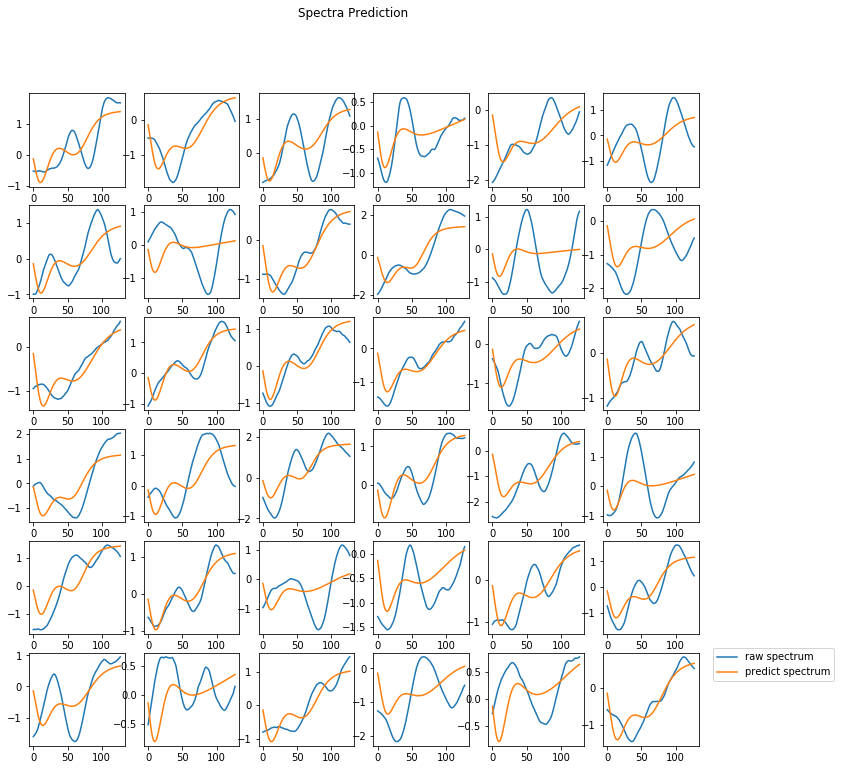

In [234]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(6, 6, figsize=(12, 12))
from sklearn import preprocessing
#y1_norm = preprocessing.normalize(x_test)
#y2_norm = preprocessing.normalize(y_predict.reshape(-1,128))
y1_norm = x_test
y2_norm = y_predict.reshape(-1,300)
axs.reshape(-1)
for i in range (0,6):
    for j in range(0,6):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
plt.legend(bbox_to_anchor=(1.1, 1.1), bbox_transform=ax.transAxes)
fig.suptitle("Spectra Prediction")

In [63]:
import keras.backend
import _archive.JoshCodes.viz as viz2

In [64]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = keras.backend.function([model.layers[0].input, 
                                            keras.backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [65]:
activation = get_ith_layer_output(model3, np.atleast_3d(x_test), 3)

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[10000,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node lstm_7/transpose_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[encoding_1/Relu/_1765]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[10000,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node lstm_7/transpose_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
activation.shape

In [ ]:
# plots the embedding maps
_ = viz2.plot.embedding_maps(activation,
                        printing,
                        plot_format,
                        'autoencoder/',
                        filename='./embeddings')
